In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tqdm

In [2]:
# Load the data by going over files in the directories

images = []
for root, dirs, files in tqdm.tqdm(os.walk("faces94")):
    for file in files:
        if file.endswith(".jpg"):
            img = cv2.imread(os.path.join(root, file), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # img = cv2.resize(img, (50, 50))
            images.append(img)

print("Number of images loaded: ", len(images))

157it [00:01, 82.10it/s]

Number of images loaded:  3059


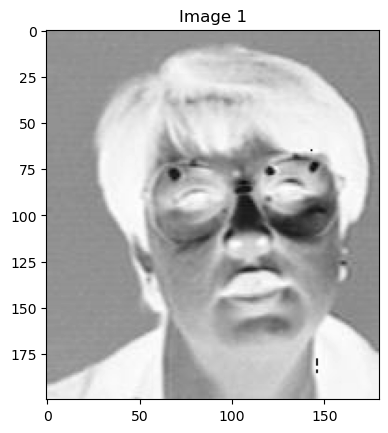

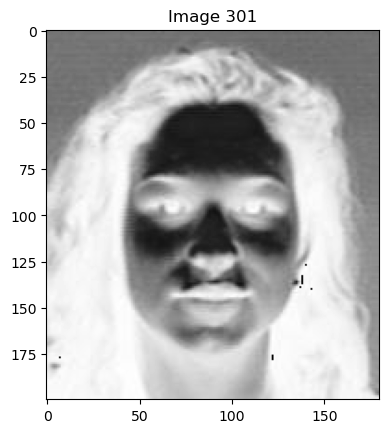

In [3]:
# Display a few images
for i in range(2):
    plt.imshow(1-images[i*300], cmap="gray")
    plt.title("Image " + str(i*300+1))
    plt.show()

# Present the average face.

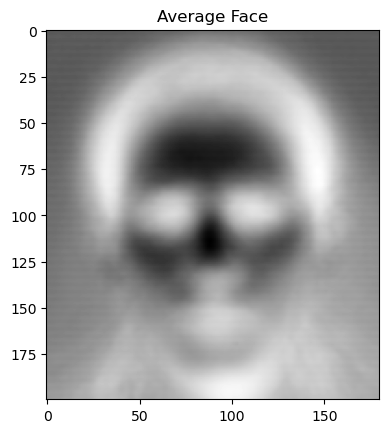

In [4]:
# Present the average face
average_face = np.mean(images, axis=0)
plt.imshow(1-average_face, cmap='gray')
plt.title("Average Face")
plt.show()

# Present 5 most dominant eigenfaces spreading the data (“ghost images”).

In [5]:
# calculate the covariance matrix
images = np.array(images)
print(images[0].shape)
images = images.reshape(images.shape[0], -1)

print(images.shape)

(200, 180)
(3059, 36000)


In [6]:
normalized_images = (images - np.mean(images, axis=0))
# covariance_matrix = normalized_images.T @ normalized_images / images.shape[0]
# dont have enough memory to calculate the covariance matrix, thus using the trick of premultiplying the images by the normalized images from the left, and calculating the eigenvectors (X*u) of X*X^T.
# thus (X*X^T)(X*u) = l (X*u)
# after we found the eigenvectors, we can multiply by X^T from left.
# thus X^T(X*X^T)(X*u) = l X^T(X*u)
# thus (X^T*X) X^T(X*u) = l X^T(X*u)
# We found that the eigen vectors of the covariance matrix are X^T(X*u)! (need to normalize them)
# normalization factor: 1/sqrt(N*l) that is  (1/sqrt(N*l))* X^T(X*u)


In [7]:
XXT = np.dot(normalized_images, normalized_images.T)
eigenvalues, eigenvectors = np.linalg.eig(XXT)
eigenvectors = np.dot(normalized_images.T, eigenvectors)
eigenvectors = np.real(eigenvectors)  # Since the imaginary part should be negligible, you can take only the real part of the eigenvectors.
# normalize the eigenvectors
eigenvectors = eigenvectors / np.sqrt(np.sum(eigenvectors**2, axis=0))

In [8]:
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [9]:
eigenvectors.shape

(36000, 3059)

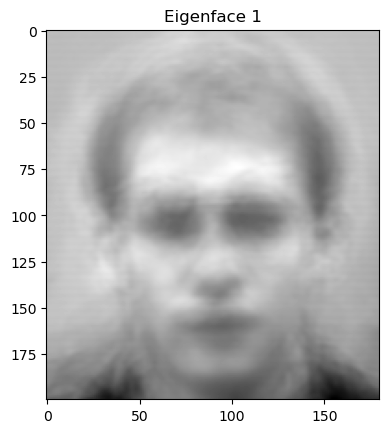

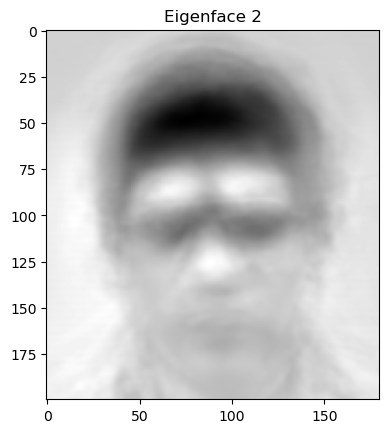

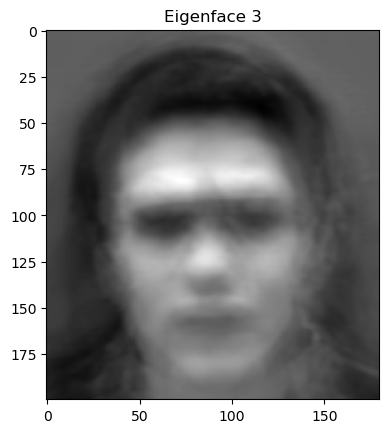

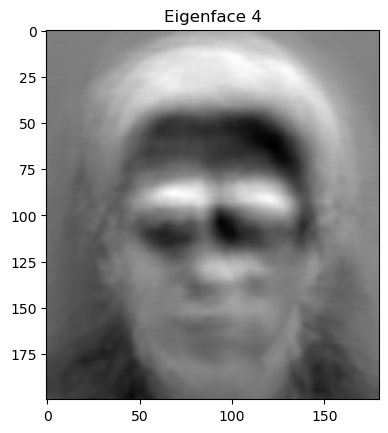

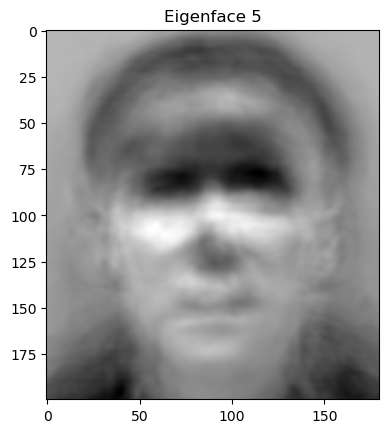

In [10]:
for i in range(5):
    eigenface = eigenvectors[:, i].reshape(200, 180)
    plt.imshow(eigenface, cmap='gray')
    plt.title("Eigenface " + str(i+1))
    plt.show()

# Decompose an image\images using PCA and reconstrucut the faces using a small number of eigen faces (2,5,10,50,100...), what is the difference between the different reconstructions, why is that?

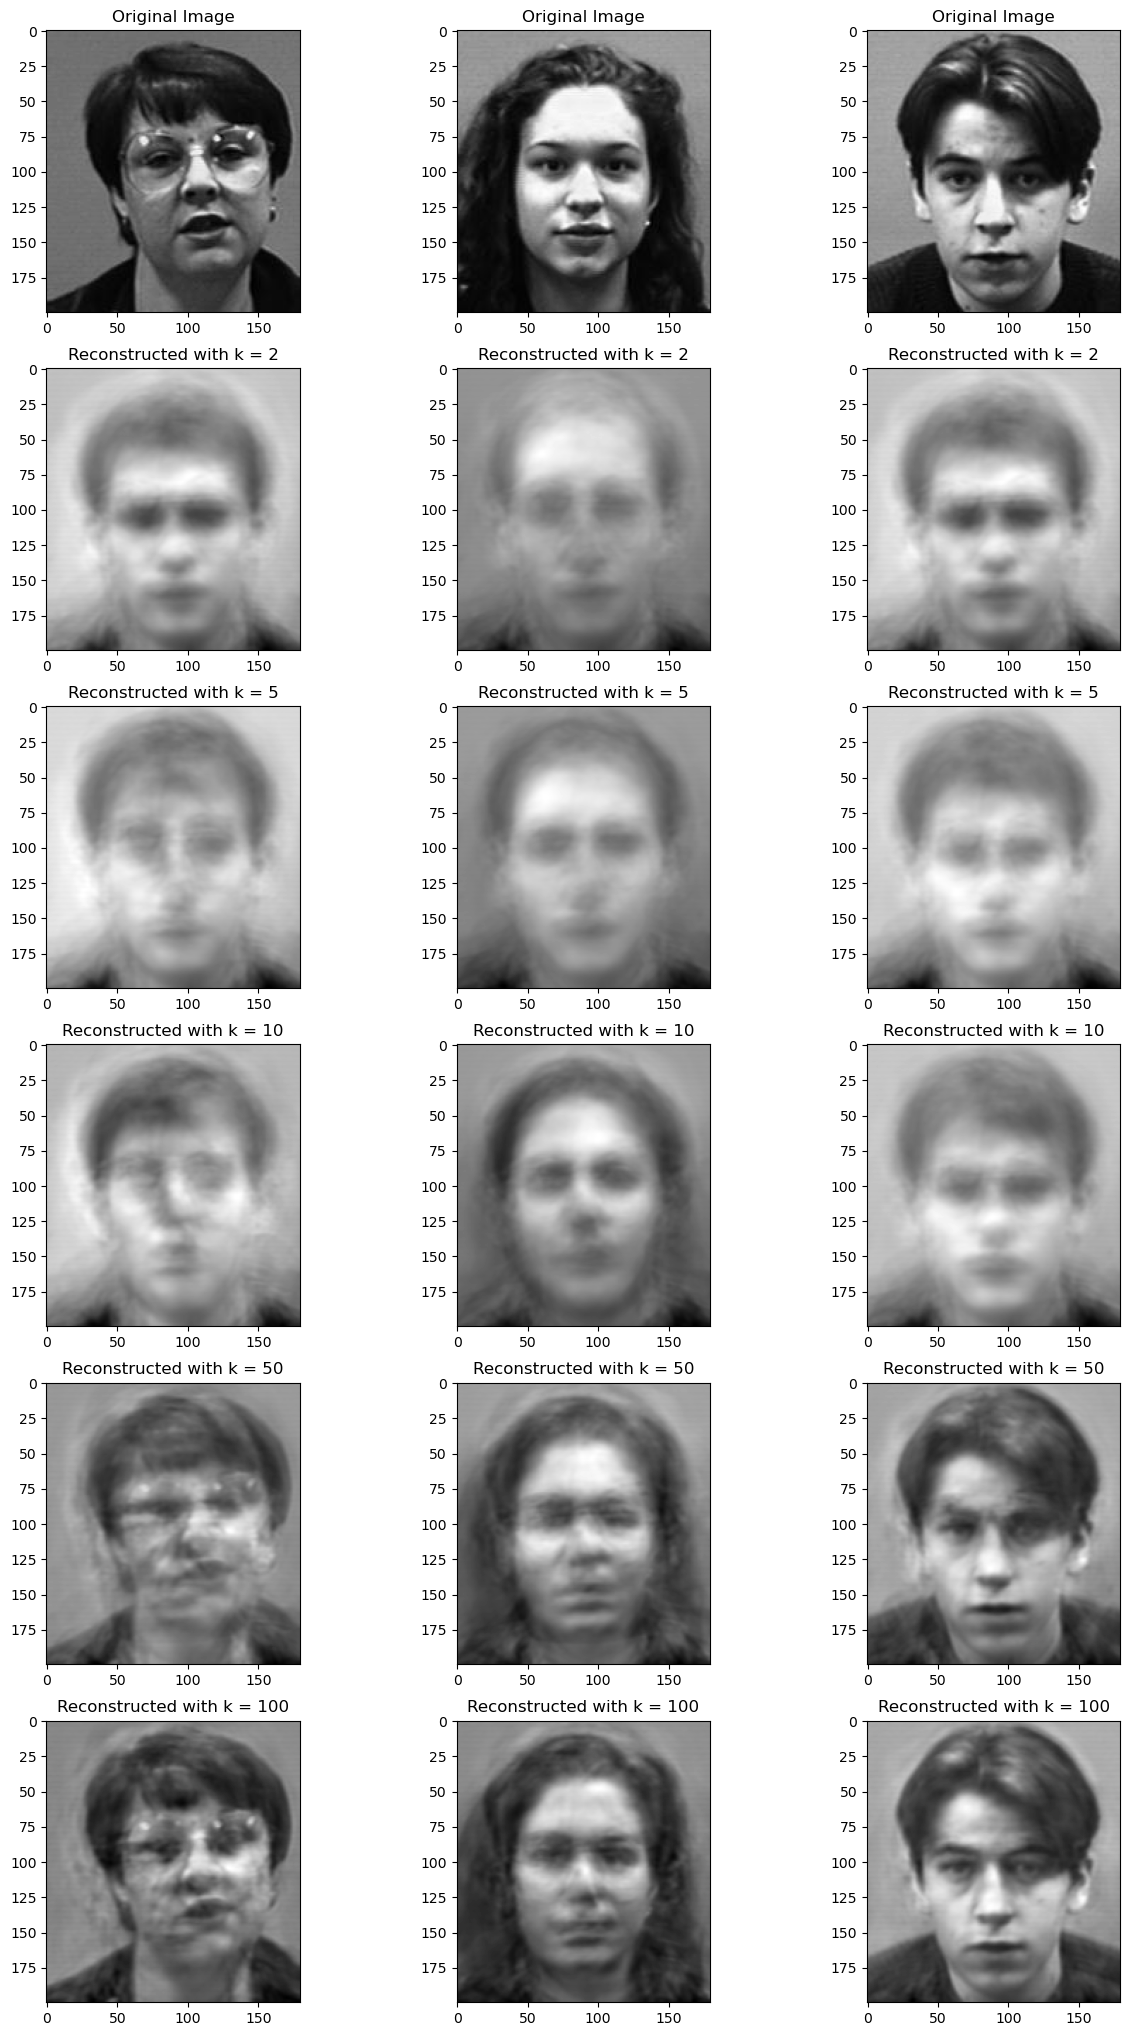

In [12]:
k_values = [2, 5, 10, 50, 100]

example_images = images[[0, 300, 600]] 

reconstructed_images = {}

for k in k_values:
    projection_matrix = eigenvectors[:, :k]
    projected_images = np.dot(example_images, projection_matrix)
    reconstructed_images[k] = np.dot(projected_images, projection_matrix.T)

# visualize the reconstructed images
k_values = [0] + k_values
plt.figure(figsize=(15, 30))

for k in k_values:
    for i in range(3):
        plt.subplot(len(k_values)+1, 3, i + k_values.index(k) * 3 + 1)
        if k == 0:
            plt.title("Original Image")
            plt.imshow(example_images[i].reshape(200, 180), cmap='gray')
        else:
            plt.title("Reconstructed with k = " + str(k))
            plt.imshow(reconstructed_images[k][i].reshape(200, 180), cmap='gray')

D:\Programs\miniconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
D:\Programs\miniconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


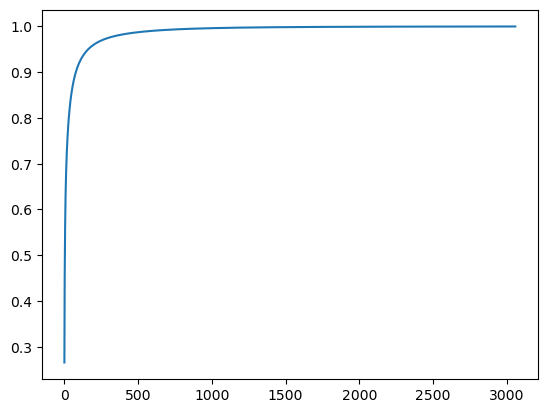

In [23]:
# Check how much information each eigenvector holds, and plot the cumulative sum of the information.

plt.plot(np.cumsum(eigenvalues)/np.sum(eigenvalues))    

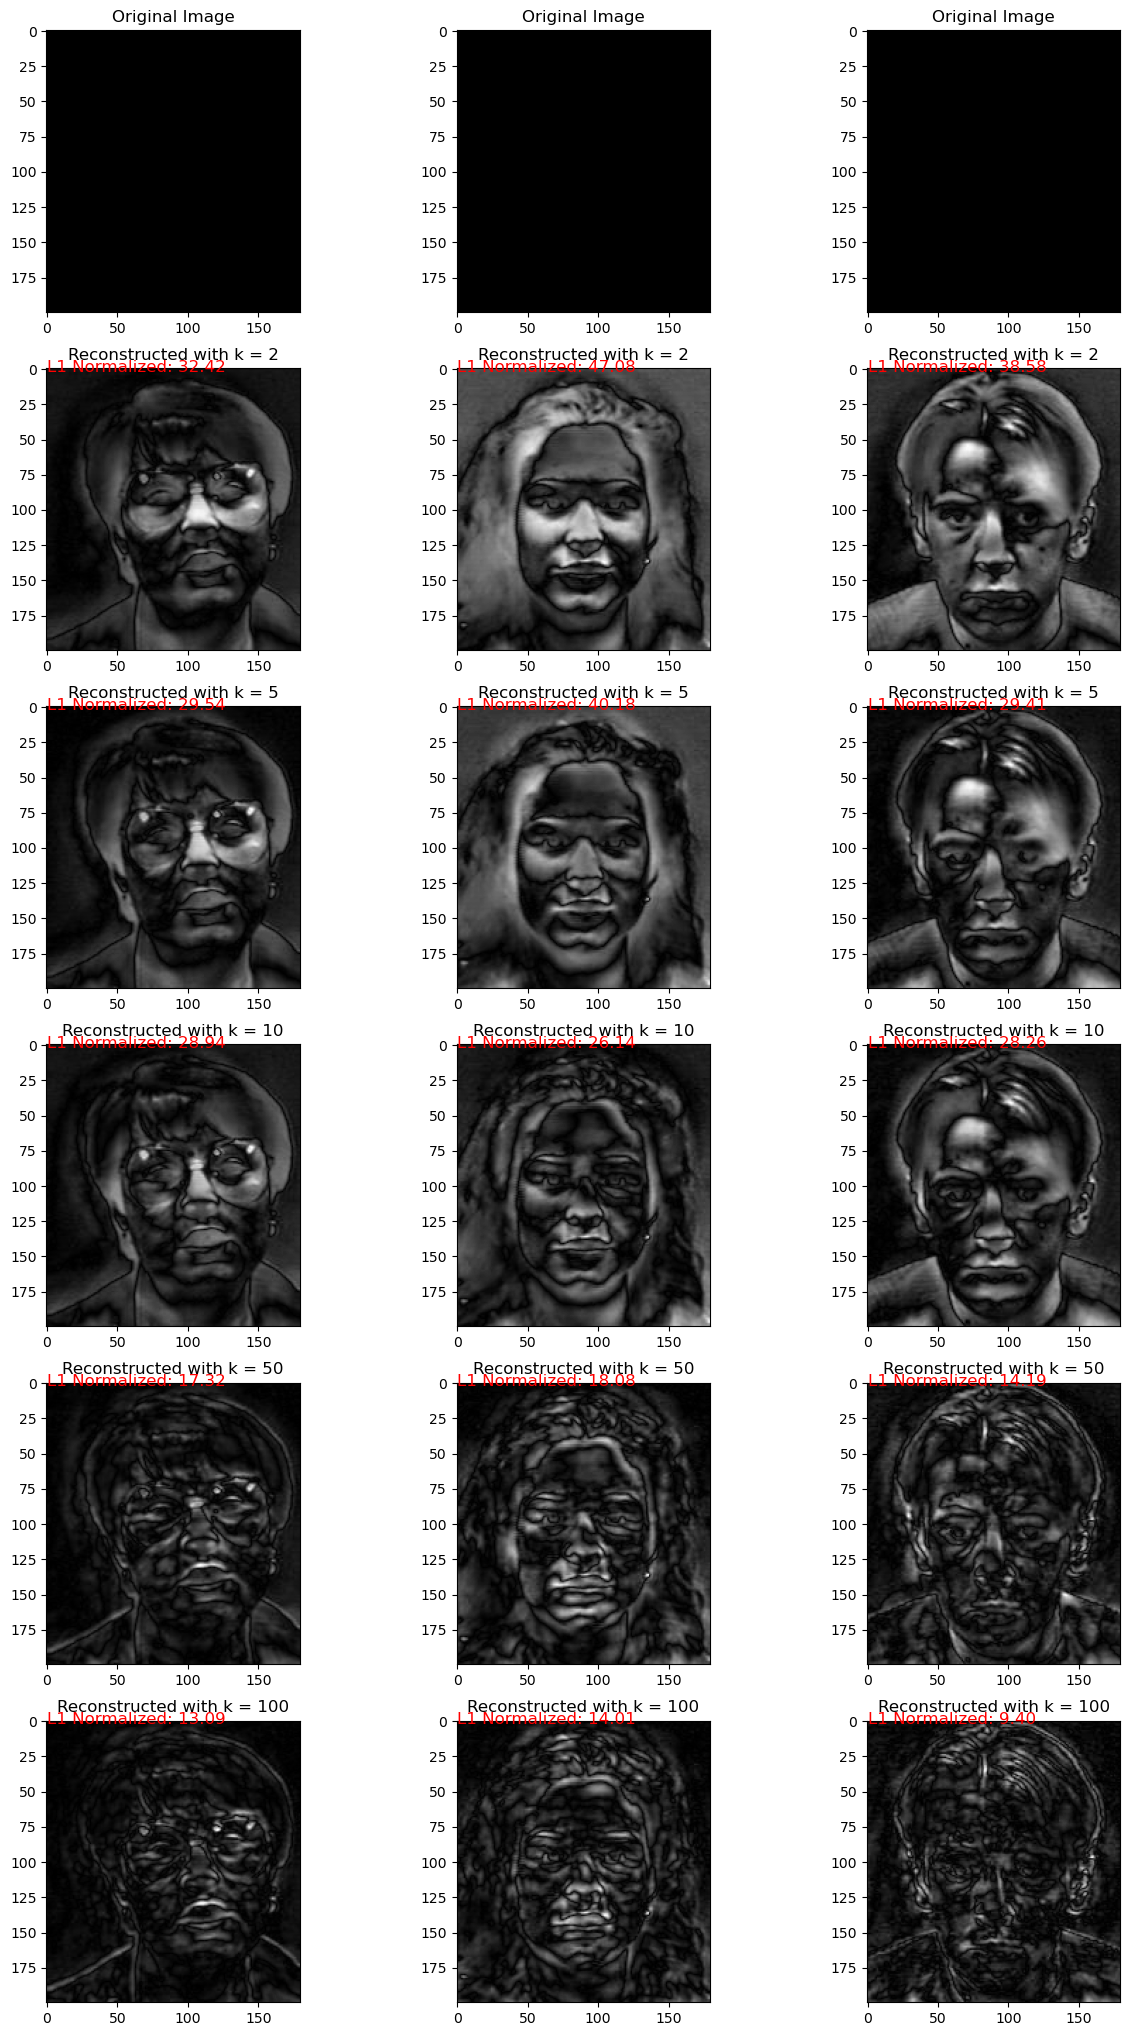

In [14]:
k_values = [2, 5, 10, 50, 100]

example_images = images[[0, 300, 600]] 

reconstructed_images = {}

for k in k_values:
    projection_matrix = eigenvectors[:, :k]
    projected_images = np.dot(example_images, projection_matrix)
    reconstructed_images[k] = np.dot(projected_images, projection_matrix.T)

# visualize the reconstructed images
k_values = [0] + k_values
plt.figure(figsize=(15, 30))

for k in k_values:
    for i in range(3):
        plt.subplot(len(k_values)+1, 3, i + k_values.index(k) * 3 + 1)
        if k == 0:
            plt.title("Original Image")
            plt.imshow(example_images[i].reshape(200, 180) - example_images[i].reshape(200, 180), cmap='gray')
        else:
            plt.title("Reconstructed with k = " + str(k))
            plt.imshow(abs(reconstructed_images[k][i].reshape(200, 180) - example_images[i].reshape(200, 180)), cmap='gray')
            plt.text(0, 2, f"L1 Normalized: {np.sum(abs(reconstructed_images[k][i].reshape(200, 180) - example_images[i].reshape(200, 180)))/200/180:.2f}", color='red', size=12)

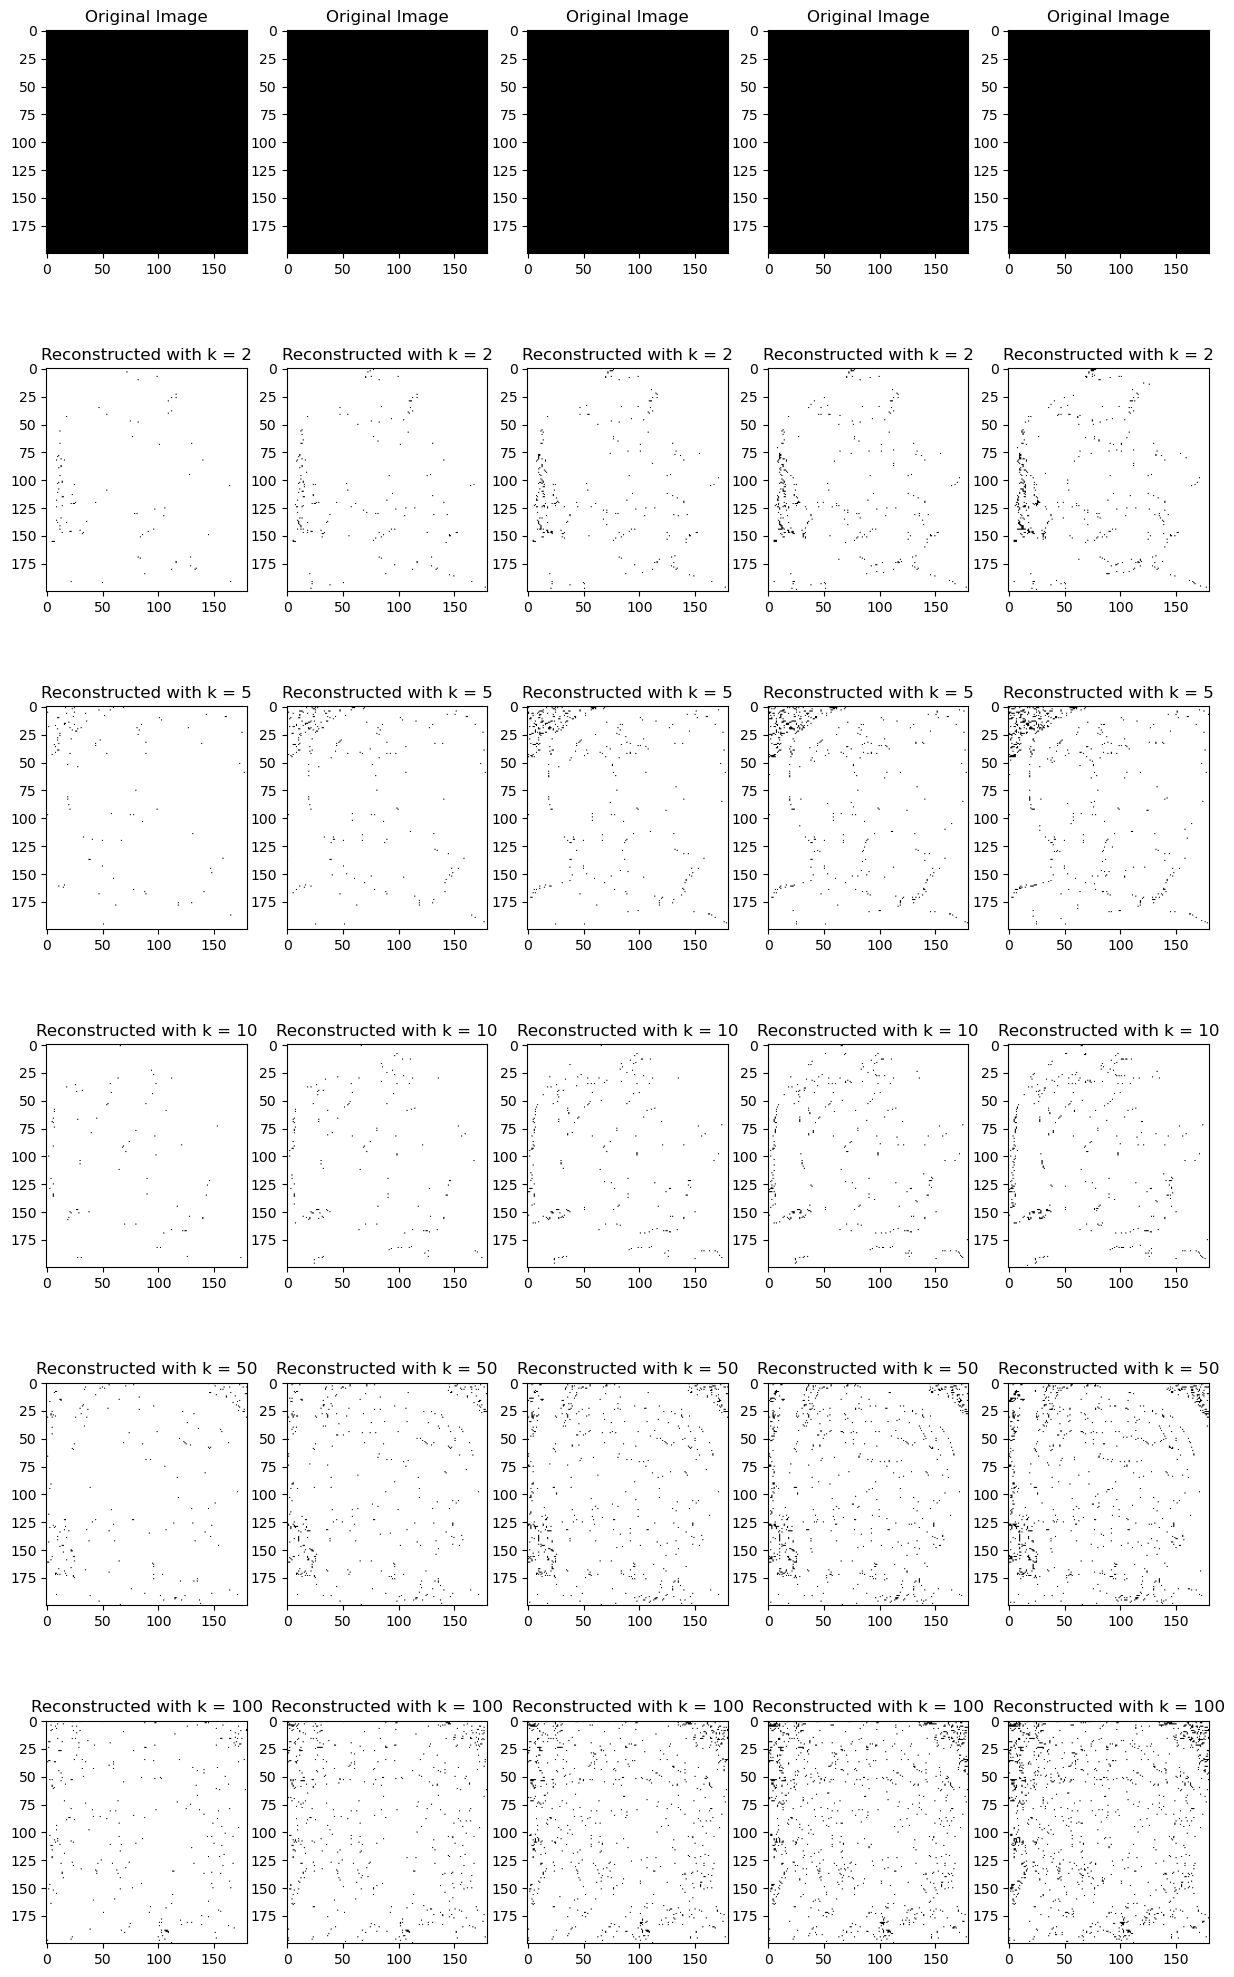

In [15]:
cut_offs = [0.1, 0.2, 0.3, 0.4, 0.5] 

plt.figure(figsize=(15, 30))
for k in k_values:
    for cut_off in cut_offs:
        plt.subplot(len(k_values)+1, len(cut_offs), cut_offs.index(cut_off) + k_values.index(k) * len(cut_offs) + 1)
        if k == 0:
            plt.title("Original Image")
            plt.imshow(example_images[0].reshape(200, 180) - example_images[0].reshape(200, 180), cmap='gray')
        else:
            plt.title("Reconstructed with k = " + str(k))
            plt.imshow(abs(reconstructed_images[k][0].reshape(200, 180) - example_images[0].reshape(200, 180))>cut_off, cmap='gray')

I define success where the normalized L1 is less than 10.

In [31]:
# load pairs data:
images = []

for root, dirs, files in os.walk("test_images_pair"):
    for file in files:
        if file.endswith(".jpg"):
            img = cv2.imread(os.path.join(root, file), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append({"image": img, "label": root.split("\\")[-1]})


In [32]:
# make a ranker model on the metric suggested 

def ranker_model(image1, image2, eigenvectors, k):
    image1 = image1.reshape(-1)
    image2 = image2.reshape(-1)
    projection_matrix = eigenvectors[:, :k]
    projected_image1 = np.dot(image1, projection_matrix)
    projected_image2 = np.dot(image2, projection_matrix)
    return np.sum(abs(projected_image1 - projected_image2))



In [39]:
# calculate ranker model precision

k_values = [1, 2, 5, 10, 50, 100, 200, 1000]


for k in k_values:
    tp = 0
    fp = 0
    for image1 in images:
        for image2 in images:
            if image1["label"] == image2["label"]:
                if ranker_model(image1["image"], image2["image"], eigenvectors, k) < 10:
                    tp += 1
            else:
                if ranker_model(image1["image"], image2["image"], eigenvectors, k) < 10:
                    fp += 1
    print(f"K: {k}, Precision: {tp/(tp+fp)}")
    print(f'tp {tp}, fp {fp}')

K: 1, Precision: 1.0
tp 20, fp 0
K: 2, Precision: 1.0
tp 20, fp 0
K: 5, Precision: 1.0
tp 20, fp 0
K: 10, Precision: 1.0
tp 20, fp 0
K: 50, Precision: 1.0
tp 20, fp 0
K: 100, Precision: 1.0
tp 20, fp 0
K: 200, Precision: 1.0
tp 20, fp 0
K: 1000, Precision: 1.0
tp 20, fp 0
